In [1]:
from __future__ import print_function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential

plt.style.use('fivethirtyeight')
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
import seaborn as sns

In [2]:
# define a function to convert a vector of time series into a 2D matrix
def convertSeriesToMatrix(vectorSeries, sequence_length):
    matrix=[]
    for i in range(len(vectorSeries)-sequence_length+1):
        matrix.append(vectorSeries[i:i+sequence_length])
    return matrix

In [3]:
# random seed
np.random.seed(1234)
   
# load raw data
df_raw = pd.read_csv('C:/Users/mengh/Dropbox/FRE_6351_Time_Series_Analysis/FRE-6351-Time-Series-Anlysis/Electric-Power-Hourly-Load-Forecasting-using-Recurrent-Neural-Networks-master/hourly_load_2016.csv', header=None)
# numpy array
df_raw = df_raw.iloc[:744,:]
df_raw_array = df_raw.values
# daily load
list_daily_load = [df_raw_array[i,:] for i in range(0, len(df_raw)) if i % 24 == 0]
# hourly load (23 loads for each day)
list_hourly_load = [df_raw_array[i,1]/100000 for i in range(0, len(df_raw)) if i % 24 != 0]
# the length of the sequnce for predicting the future value
sequence_length = 23

# convert the vector to a 2D matrix
matrix_load = convertSeriesToMatrix(list_hourly_load, sequence_length)

# shift all data by mean
matrix_load = np.array(matrix_load)
shifted_value = matrix_load.mean()
matrix_load -= shifted_value
print ("Data  shape: ", matrix_load.shape)


Data  shape:  (691, 23)


In [4]:
print(matrix_load[0])
print(matrix_load[1])

[-4.89989348 -5.45070048 -5.84608878 -6.06698278 -6.07209078 -5.87505088
 -5.26652138 -4.95020008 -4.21197068 -3.56569848 -2.86580798 -2.29728268
 -1.86698148 -1.77608268 -1.96008858 -1.84501578 -0.24328398 -0.07492628
 -0.44330368 -0.85896348 -1.45637558 -2.24842978 -3.32673708]
[-5.45070048 -5.84608878 -6.06698278 -6.07209078 -5.87505088 -5.26652138
 -4.95020008 -4.21197068 -3.56569848 -2.86580798 -2.29728268 -1.86698148
 -1.77608268 -1.96008858 -1.84501578 -0.24328398 -0.07492628 -0.44330368
 -0.85896348 -1.45637558 -2.24842978 -3.32673708 -4.68910308]


In [5]:
# split dataset: 90% for training and 10% for testing
train_row = int(round(69.0/691.0 * matrix_load.shape[0]))
print(train_row)

train_set = matrix_load[:train_row, :]
print(train_set)

69
[[-4.89989348 -5.45070048 -5.84608878 ... -1.45637558 -2.24842978
  -3.32673708]
 [-5.45070048 -5.84608878 -6.06698278 ... -2.24842978 -3.32673708
  -4.68910308]
 [-5.84608878 -6.06698278 -6.07209078 ... -3.32673708 -4.68910308
  -5.19392678]
 ...
 [ 1.71605332  0.48946402 -1.02335848 ...  6.24298282  5.89886832
   5.24345192]
 [ 0.48946402 -1.02335848 -2.76348178 ...  5.89886832  5.24345192
   4.11162862]
 [-1.02335848 -2.76348178 -3.14773218 ...  5.24345192  4.11162862
   2.47181472]]


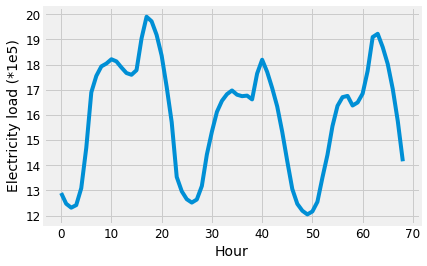

In [6]:
# split dataset: 90% for training and 10% for testing
train_row = int(round(622.0/691.0 * matrix_load.shape[0]))

train_set = matrix_load[:train_row, :]

# shuffle the training set (but do not shuffle the test set)
# np.random.shuffle(train_set)
# the training set
X_train = train_set[:, :-1]
# the last column is the true value to compute the mean-squared-error loss
y_train = train_set[:, -1] 
# the test set
X_test = matrix_load[train_row:, :-1]
y_test = matrix_load[train_row:, -1]

# the input to LSTM layer needs to have the shape of (number of samples, the dimension of each element)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

plt.plot(y_test + shifted_value)
plt.xlabel('Hour')
plt.ylabel('Electricity load (*1e5)')
plt.show()

In [9]:
# build the model
model = Sequential()
# layer 1: LSTM
model.add(LSTM( input_dim=1, output_dim=50, return_sequences=True))
model.add(Dropout(0.2))
# layer 2: LSTM
model.add(LSTM(output_dim=100, return_sequences=False))
model.add(Dropout(0.2))
# layer 3: dense
# linear activation: a(x) = x
model.add(Dense(output_dim=1, activation='linear'))
# compile the model
model.compile(loss="mse", optimizer="rmsprop")
# train the model
model.fit(X_train, y_train, batch_size=512, nb_epoch=200, validation_split=0.05, verbose=1)

# evaluate the result
test_mse = model.evaluate(X_test, y_test, verbose=1)
print ('\nThe mean squared error (MSE) on the test data set is %.3f over %d test samples.' % (test_mse, len(y_test)))

# get the predicted values
predicted_values = model.predict(X_test)
num_test_samples = len(predicted_values)
predicted_values = np.reshape(predicted_values, (num_test_samples,1))


# # save the result into txt file
# test_result = np.vstack((predicted_values, y_test)) + shifted_value
# np.savetxt('output_load_forecasting_result.txt', test_result)

C:\Users\mengh\Anaconda3\envs\python35\lib\site-packages\ipykernel_launcher.py:4: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  after removing the cwd from sys.path.
C:\Users\mengh\Anaconda3\envs\python35\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 1), units=50)`
  after removing the cwd from sys.path.
C:\Users\mengh\Anaconda3\envs\python35\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=False, units=100)`
  import sys
C:\Users\mengh\Anaconda3\envs\python35\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="linear", units=1)`
  # This is added back by InteractiveShellApp.init_path()
C:\Users\mengh\Anaconda3\envs\python35\lib\site-packages\ipykernel_launcher.py:16: U

Train on 590 samples, validate on 32 samples
Epoch 1/200
590/590 [==============================] - 2s 3ms/step - loss: 8.2467 - val_loss: 5.7166
Epoch 2/200
590/590 [==============================] - 0s 296us/step - loss: 7.4326 - val_loss: 5.4282
Epoch 3/200
590/590 [==============================] - 0s 286us/step - loss: 6.8102 - val_loss: 5.1714
Epoch 4/200
590/590 [==============================] - 0s 274us/step - loss: 6.0484 - val_loss: 4.5150
Epoch 5/200
590/590 [==============================] - 0s 277us/step - loss: 4.8387 - val_loss: 3.7979
Epoch 6/200
590/590 [==============================] - 0s 264us/step - loss: 3.6948 - val_loss: 3.1379
Epoch 7/200
590/590 [==============================] - 0s 286us/step - loss: 3.5183 - val_loss: 2.9572
Epoch 8/200
590/590 [==============================] - 0s 265us/step - loss: 2.6566 - val_loss: 2.5307
Epoch 9/200
590/590 [==============================] - 0s 304us/step - loss: 2.0838 - val_loss: 2.3780
Epoch 10/200
590/590 [========

<Figure size 432x288 with 0 Axes>

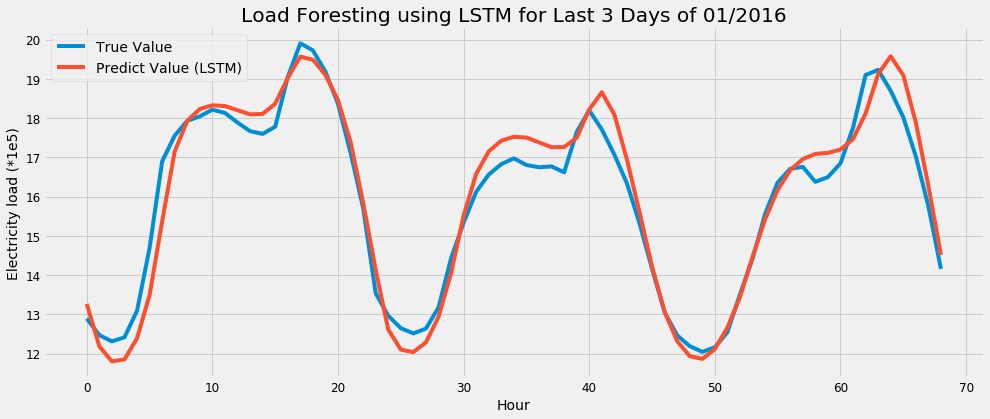

In [10]:
plt.style.use('fivethirtyeight')
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
import seaborn as sns

# plot the results
fig = plt.figure()
plt.figure(figsize=(15, 6))
plt.plot(y_test + shifted_value, label='True Value')
plt.plot(predicted_values + shifted_value, label='Predict Value (LSTM)')
plt.xlabel('Hour')
plt.ylabel('Electricity load (*1e5)')
plt.title('Load Foresting using LSTM for Last 3 Days of 01/2016')
plt.legend(loc='best')
plt.show()
fig.savefig('output_load_forecasting.jpg', bbox_inches='tight')

In [12]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(predicted_values + shifted_value, y_test + shifted_value)
print(mse)

0.26619740303544664
